In [1]:

import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt


In [2]:
import matplotlib as mpl
print(mpl.__version__)

3.2.1


In [3]:
inferenceLocations = ['Beaglebone','Amazon-EC2']
vibSamples = ['4096','8192','16384','32768','65536']
vibSampleLabels = [r'$2^{12}$',r'$2^{13}$',r'$2^{14}$',r'$2^{15}$',r'$2^{16}$']
basePath = 'Edge-Device-Latency/'
modelId = 'No-Vib'
deviceId = 'Amazon-EC2'
numSamples = 900
numColumns = 3

latencyVals = np.zeros((numSamples,len(inferenceLocations),len(vibSamples)))
computeVals = np.zeros((numSamples,len(inferenceLocations),len(vibSamples)))
columns = None

In [4]:
for i in range(len(vibSamples)):
    for j in range(len(inferenceLocations)):
        
        if inferenceLocations[j] == 'Beaglebone':
            modelId = 'returnPSD'
            thisDF = pd.read_csv(basePath + inferenceLocations[j] +'_' + modelId + '_' + vibSamples[i] + '.csv')
            latencyVals[:,j,i] = thisDF.values[-numSamples:,3]
            computeVals[:,j,i] = thisDF.values[-numSamples:,1] + thisDF.values[-numSamples:,2]
        else:
            modelId = 'No-Vib'
            thisDF = pd.read_csv(basePath + inferenceLocations[j] +'_' + modelId + '_' + vibSamples[i] + '.csv')
            latencyVals[:,j,i] = thisDF.values[-numSamples:,3]
            computeVals[:,j,i] = thisDF.values[-numSamples:,2]
            
        
        print(thisDF.values.shape)


        



(997, 4)
(1021, 4)
(1000, 4)
(1000, 4)
(1000, 4)
(1000, 4)
(1000, 4)
(948, 4)
(1000, 4)
(1000, 4)


mean latency, max latency, Max Score Difference, MSE

In [5]:
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']

def box_plot_compare(data,labels,
             xlabel='',ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=np.arange(len(colors)),template='publication',
             xtickpad=5,showfliers=False,legend_loc='best',max_cutoff=0,min_cutoff=0,plot_type='violin'):
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()
        
    position = [i+1 for i in range(data.shape[1])]
    tickPositions = []
    phantomLines = []
        
    for i in range(data.shape[-1]):
        
        max_index = data.shape[0] - max_cutoff
        min_index = min_cutoff
        
        thisData = np.sort(data[...,i],axis=0)[min_index:max_index,:]
        
        if plot_type=='violin':

            violin_parts = plt.violinplot(thisData,
                      positions = position,
                      showmeans=False,
                      showmedians=False,
                      showextrema=False)

            for counter, pc in enumerate(violin_parts['bodies']):
                pc.set_facecolor(colors[counter])
                pc.set_edgecolor('black')
                pc.set_alpha(1)

                if i == 0:
                    line, = plt.plot([1,1],color=colors[counter])
                    phantomLines.append(line)
                    
        else:
           
            bp = plt.boxplot(thisData,
                            positions=position,
                            showfliers=showfliers,
                            patch_artist=True,
                            meanline=False,
                            notch=False,
                            medianprops={'color':'black',
                                         'linewidth':2},
                            whiskerprops={'linewidth':2},
                            capprops={'linewidth':2},
                            widths=0.75)
            
            for counter,patch in enumerate(bp['boxes']):
                # change outline color
                patch.set(color=colors[counter], linewidth=2)
                patch.set_facecolor(colors[counter])
                
                if i == 0:
                    line, = plt.plot([1,1],color=colors[counter])
                    phantomLines.append(line)
            
        tickPositions.append(np.mean(position))    
        position = [position[i] + data.shape[1] + 1 for i in range(len(position))]
            
    ax = plt.gca()

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    ax.set_xticks(tickPositions)
    ax.tick_params(axis='x', which='major', pad=xtickpad)
    ax.legend(tuple(phantomLines),tuple(inferenceLocations),loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
    
    [phantomLines[i].set_visible(False) for i in range(len(phantomLines))]
    
    plt.xlabel(r'\textbf{' + xlabel + '}')
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.png',transparent=transparent)

    plt.show()
    

  
def bar_chart_compare(data,labels,dataLabels,
             xlabel='',ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=np.arange(len(colors)),template='publication',max_cutoff=0,min_cutoff=0,
             xtickpad=5,showfliers=False,legend_loc='best'):
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()
        
    x = np.arange(data.shape[-1])
    tickPositions = x.tolist() 
    phantomLines = []
    width = .7 / len(dataLabels)
        
    means = np.mean(data,axis=0)
    stdev = np.std(data,axis=0)


    for j in range(data.shape[-2]):

        plt.bar(x - 0.35 + (j+.5) * width, means[j,:], width, label=dataLabels[j])

#         tickPositions.append(np.mean(position))    
#         position = [position[i] + data.shape[1] + 1 for i in range(len(position))]
            
    ax = plt.gca()

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    ax.set_xticks(tickPositions)
    ax.tick_params(axis='x', which='major', pad=xtickpad)
#     ax.legend(tuple(phantomLines),tuple(dataLabels),loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
    plt.legend(loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
    
    plt.xlabel(r'\textbf{' + xlabel + '}')
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.png',transparent=transparent)

    plt.show()
    

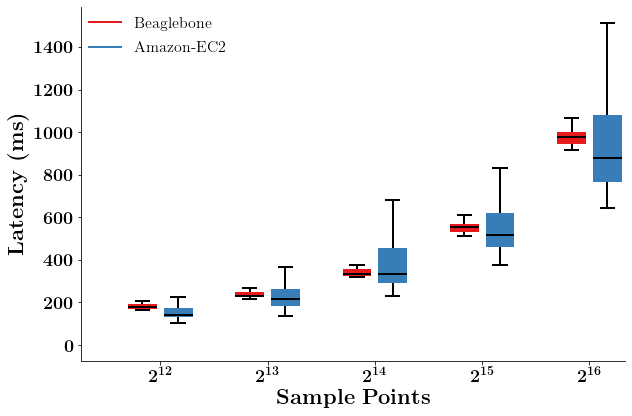

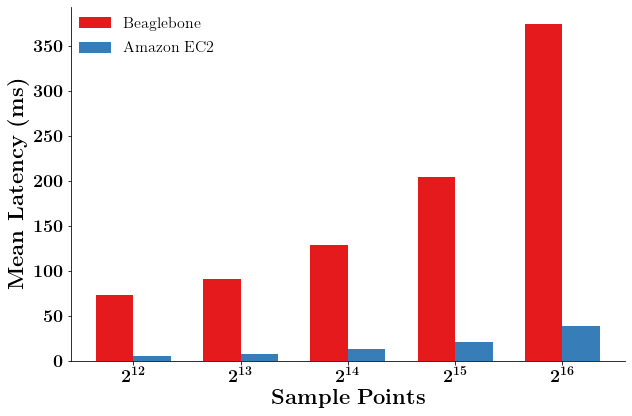

In [6]:
box_plot_compare((latencyVals),vibSampleLabels,savefig=True,filename='EdgeCloud_TotalLatency',
         template='presentation',xlabel='Sample Points',color_order=np.zeros(6).astype(int),ylabel='Latency (ms)',
         showfliers=False,legend_loc='upper left',max_cutoff=2,plot_type='box',
         log_y=False)

bar_chart_compare((computeVals),vibSampleLabels,['Beaglebone','Amazon EC2'],savefig=True,filename='EdgeVsCloud_ComputeLatency',
         template='presentation',xlabel='Sample Points',color_order=np.zeros(6).astype(int),ylabel='Mean Latency (ms)',
         showfliers=False,legend_loc='upper left',
         log_y=False)

In [7]:
latencyVals.shape

(900, 2, 5)